In [1]:
import re
import pandas as pd
pd.options.mode.chained_assignment = None
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import string
from datetime import datetime
from twitter_source.database_util import DatabaseUtil
from matplotlib import pyplot as plt
import seaborn as sns
import quandl
from sklearn import preprocessing
%matplotlib inline

* data preparing

In [2]:
# connect to the sqlite3 db file, utilizing the customized module
db = DatabaseUtil()
engine = db.get_engine()
conn = engine.connect()

In [3]:
df = pd.read_sql('select * from tweets', conn)

In [4]:
# twitter text processing and cleaning function
def process_words(raw, remove_punc=False, stem=False):
    link_pattern = [
        r'(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*$',
    ]
    clean = raw.lower().strip()
    for ptn in link_pattern:
        clean = re.sub(ptn, '', clean)
    if remove_punc:
        nopunc = [c for c in clean if c not in string.punctuation]
        raw = ''.join(nopunc)

    stopwords_list = []
    stopwords_list_en = set(stopwords.words('english'))
    stopwords_list_fr = set(stopwords.words('french'))
    stopwords_list.extend(stopwords_list_en)
    stopwords_list.extend(stopwords_list_fr)
   
    nostop = [w for w in raw.split() if w.lower() not in stopwords_list]
    if stem:
        stemmer = PorterStemmer()
        return ' '.join([stemmer.stem(t) for t in nostop])
    else:
        return ' '.join(nostop)

In [5]:
df['tweet_clean'] = df['tweet'].apply(lambda t: process_words(t, remove_punc=True))

In [6]:
# transform tweet timestamp from string format to datetime
df['date'] = df['time'].apply(lambda t: re.findall('\d\d\d\d-\d\d-\d\d',t)[0])
df['date'] = df['date'].apply(lambda s: datetime.strptime(s,'%Y-%m-%d'))

In [7]:
# subsetting the dataframe, grouping by tweets categories
news = df[df['type'] == 'biznews']
realtor = df[df['type'] == 'realtor']
searched = df[df['type'] == 'search']

* Exploratory Analysis

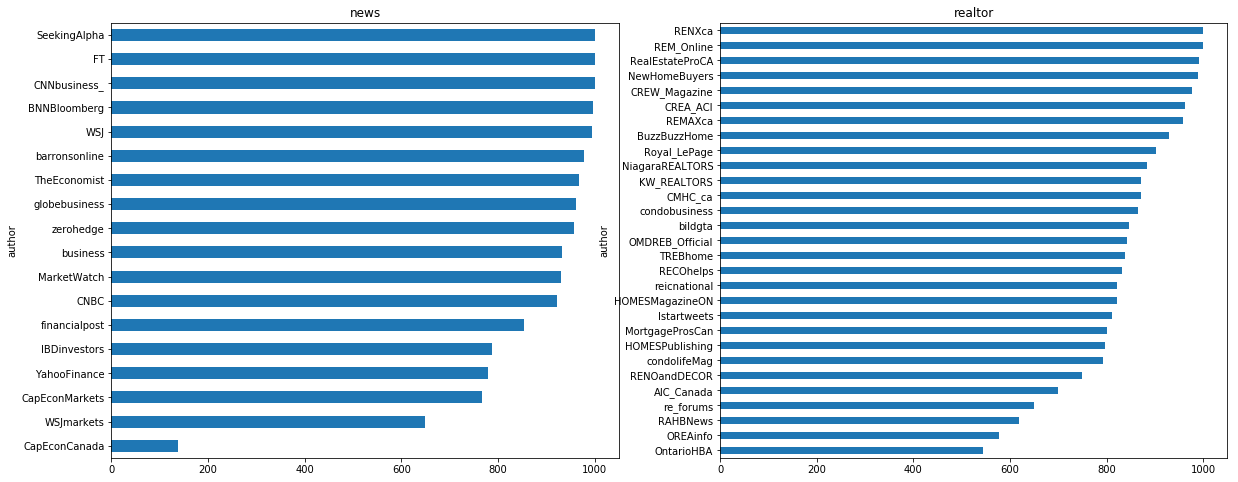

In [8]:
# count the number of tweets collected from each news outlet
cntfig = plt.figure(figsize=(20,8))
f1 = cntfig.add_subplot(121)
f1 = news.groupby('author')['tweet'].count().sort_values().plot(kind='barh')
f2 = cntfig.add_subplot(122)
f2 = realtor.groupby('author')['tweet'].count().sort_values().plot(kind='barh')
axes = cntfig.get_axes()
axes[0].set_title('news')
axes[1].set_title('realtor')
plt.show()

In [9]:
def find_sent(df):
    analyzer = SentimentIntensityAnalyzer()
    df['sentiment'] = df['tweet'].apply(lambda t: analyzer.polarity_scores(t)['compound'])
    focus = df[['author','date','tweet','sentiment']]
    focus = df[['author','date','tweet','sentiment']]
    filter_time = focus['date'] >= datetime(2018,1,1)
    recent = focus[filter_time].set_index('date')
    return recent

In [10]:
news_recent = find_sent(news)
realtor_recent = find_sent(realtor)
searched_recent = find_sent(searched)

In [11]:
def sent_trend(df):
    grouper = df.groupby(pd.Grouper(freq='M'))
    groupby_month = grouper.mean().reset_index()
    f = plt.scatter(x=groupby_month['date'],y=groupby_month['sentiment'])
    return f

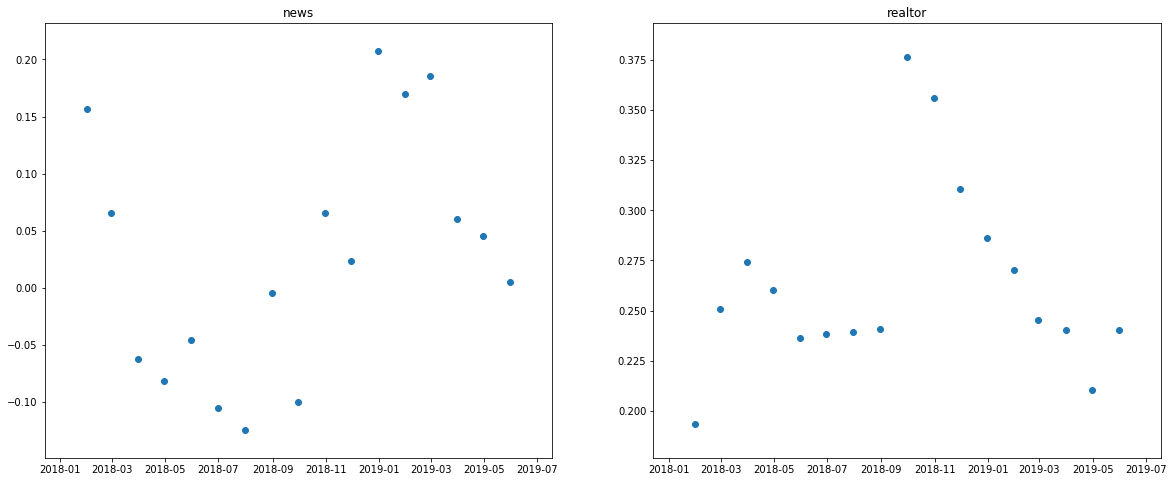

In [12]:
trendfig = plt.figure(figsize=(20,8))
fn = trendfig.add_subplot(121)
fn = sent_trend(news_recent)
fr = trendfig.add_subplot(122)
fr = sent_trend(realtor_recent)
axes = trendfig.get_axes()
axes[0].set_title('news')
axes[1].set_title('realtor')
plt.show()

In [13]:
def sent_ingroup(df):
    groupby_author = df.groupby('author').mean().reset_index().sort_values('sentiment')
#     f = groupby_author.plot(x='author',kind='barh', figsize = (8,6))
    f = plt.barh(groupby_author['author'], groupby_author['sentiment'])
    return f

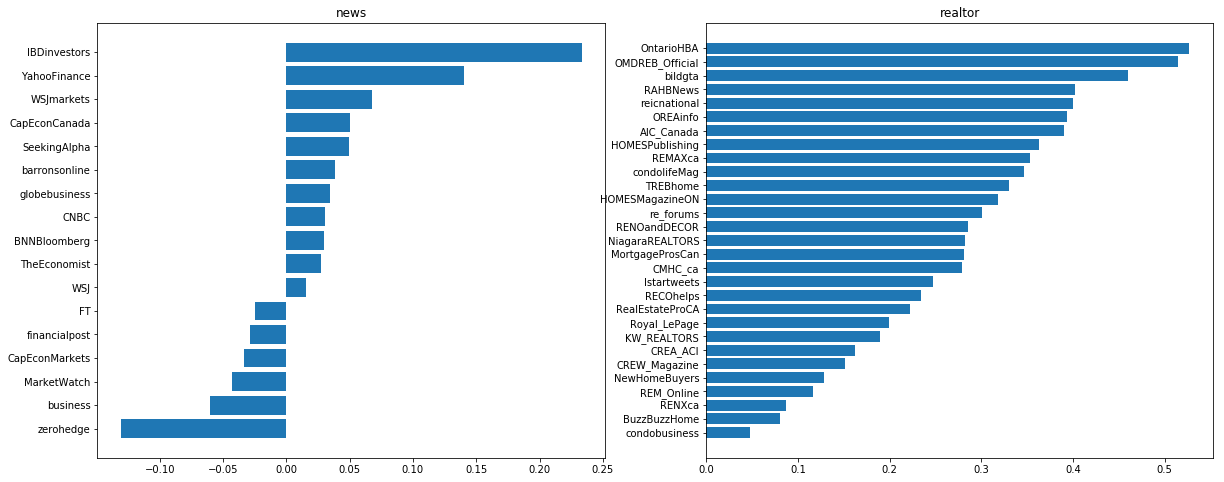

In [14]:
groupfig = plt.figure(figsize=(20,8))
fn = groupfig.add_subplot(121)
fn = sent_ingroup(news_recent)
fr = groupfig.add_subplot(122)
fr = sent_ingroup(realtor_recent)
axes = groupfig.get_axes()
axes[0].set_title('news')
axes[1].set_title('realtor')
plt.show()